# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [66]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.01896541960606335


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    print(param_name)
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b1
b1 max relative error: 2.738421e-09
W1
W1 max relative error: 4.090897e-09
b2
b2 max relative error: 4.447656e-11
W2
W2 max relative error: 3.440708e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.015629050837161474


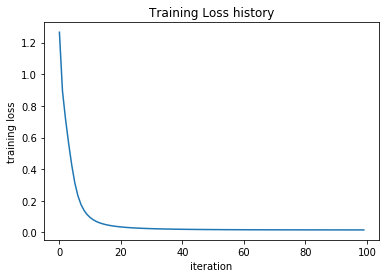

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [30]:
from cs231n.data_utils import load_CIFAR10
from sklearn.decomposition import PCA

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)
    
    #dimensionality reduction
    pca = PCA(n_components=0.9)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 99)
Train labels shape:  (49000,)
Validation data shape:  (1000, 99)
Validation labels shape:  (1000,)
Test data shape:  (1000, 99)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [17]:
input_size = X_train.shape[1]
hidden_size = 90
num_classes = 10
np.random.seed(7)
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=256,
            learning_rate=1.5821e-3, learning_rate_decay=0.95,
            reg=0.12, verbose=True)

# stats = net.train(X_train, y_train, X_val, y_val,
#             num_iters=1500, batch_size=1024,
#             learning_rate=2.3e-3, learning_rate_decay=0.95,
#             reg=1.8, verbose=True)

# Predict on the validation set
train_acc = (net.predict(X_train) == y_train).mean()
print('Training accuracy: ', train_acc)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)


iteration 0 / 2000: loss 2.302571
iteration 100 / 2000: loss 1.752482
iteration 200 / 2000: loss 1.656304
iteration 300 / 2000: loss 1.618049
iteration 400 / 2000: loss 1.605927
iteration 500 / 2000: loss 1.552249
iteration 600 / 2000: loss 1.537486
iteration 700 / 2000: loss 1.541737
iteration 800 / 2000: loss 1.588125
iteration 900 / 2000: loss 1.456201
iteration 1000 / 2000: loss 1.507989
iteration 1100 / 2000: loss 1.478348
iteration 1200 / 2000: loss 1.477825
iteration 1300 / 2000: loss 1.484268
iteration 1400 / 2000: loss 1.286078
iteration 1500 / 2000: loss 1.406673
iteration 1600 / 2000: loss 1.480396
iteration 1700 / 2000: loss 1.338005
iteration 1800 / 2000: loss 1.456706
iteration 1900 / 2000: loss 1.377169
Training accuracy:  0.5356122448979592
Validation accuracy:  0.497
Test accuracy:  0.522


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

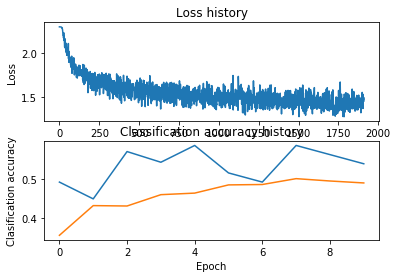

In [14]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [ ]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    print(W1.shape)
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    print(W1.shape)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [32]:
results = {}
total_stats = {}
best_val = -1
best_net = None

input_size = X_train.shape[1]
num_classes = 10


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
hidden_states = np.array([50,90])
learning_rates = 10 ** -(np.random.rand(15)*1 + 2.3) # range [1e-3.3, 1e-2.3]
regularization_strengths = np.random.rand(5) * 10 # range [2.5e4, 5e4]

for n_h in hidden_states:
    for lr in learning_rates:
        for reg in regularization_strengths:
            net = TwoLayerNet(input_size, n_h, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                              num_iters=500, batch_size=256,
                              learning_rate=lr, learning_rate_decay=0.95,
                              reg=reg, verbose=False)
            y_train_pred = net.predict(X_train)
            y_val_pred = net.predict(X_val)
            train_accuracy = np.mean(y_train_pred == y_train)
            val_accuracy = np.mean(y_val_pred == y_val)
            results[(n_h, lr, reg)] = (train_accuracy, val_accuracy)
            total_stats[(n_h, lr, reg)] = stats
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for n_h, lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(n_h, lr, reg)]
    print('Nh %e lr %e reg %e train accuracy: %f val accuracy: %f' % (
                n_h, lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:100: RuntimeWarning: divide by zero encountered in log
  Li = - np.log(probs[range(N), y])
D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:97: RuntimeWarning: overflow encountered in exp
  exp = np.exp(scores)
D:\Deep Learning - Stanford\assignment1\cs231n\classifiers\neural_net.py:98: RuntimeWarning: invalid value encountered in true_divide
  probs = exp / np.sum(exp, axis = 1, keepdims = True)


Nh 5.000000e+01 lr 7.432669e-04 reg 1.025463e-01 train accuracy: 0.399163 val accuracy: 0.406000
Nh 5.000000e+01 lr 7.432669e-04 reg 1.266429e+00 train accuracy: 0.392286 val accuracy: 0.399000
Nh 5.000000e+01 lr 7.432669e-04 reg 2.646953e+00 train accuracy: 0.386469 val accuracy: 0.392000
Nh 5.000000e+01 lr 7.432669e-04 reg 6.421652e+00 train accuracy: 0.374041 val accuracy: 0.390000
Nh 5.000000e+01 lr 7.432669e-04 reg 9.696924e+00 train accuracy: 0.359796 val accuracy: 0.361000
Nh 5.000000e+01 lr 8.516058e-04 reg 1.025463e-01 train accuracy: 0.411633 val accuracy: 0.419000
Nh 5.000000e+01 lr 8.516058e-04 reg 1.266429e+00 train accuracy: 0.408898 val accuracy: 0.427000
Nh 5.000000e+01 lr 8.516058e-04 reg 2.646953e+00 train accuracy: 0.400388 val accuracy: 0.421000
Nh 5.000000e+01 lr 8.516058e-04 reg 6.421652e+00 train accuracy: 0.379551 val accuracy: 0.397000
Nh 5.000000e+01 lr 8.516058e-04 reg 9.696924e+00 train accuracy: 0.366367 val accuracy: 0.370000
Nh 5.000000e+01 lr 9.785683e-0

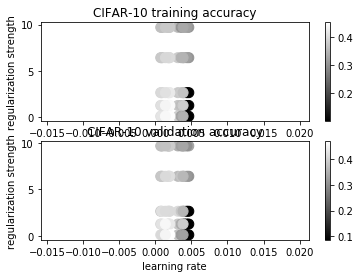

In [34]:
# Visualize the cross-validation results
nh = 90
x_scatter = [x[1] for x in results if x[0] == nh]
y_scatter = [x[2] for x in results if x[0] == nh]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results if x[0] == nh]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('learning rate')
plt.ylabel('regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results if x[0] == nh] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('learning rate')
plt.ylabel('regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

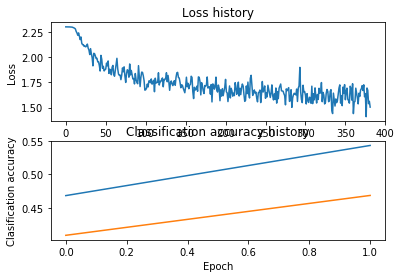

In [40]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(total_stats[(90,0.0020100816002458304,0.1025462894831819)]['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(total_stats[(90,0.0020100816002458304,0.1025462894831819)]['train_acc_history'], label='train')
plt.plot(total_stats[(90,0.0020100816002458304,0.1025462894831819)]['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [85]:
n_h = 500
lr = 0.0020100816002458304
reg = 0.1025462894831819

best_net = TwoLayerNet(input_size, n_h, num_classes)
stats = best_net.train(X_train, y_train, X_val, y_val,
                              num_iters=3000, batch_size=256,
                              learning_rate=lr, learning_rate_decay=0.9,
                              reg=reg, verbose=True)

iteration 0 / 3000: loss 2.302614
iteration 100 / 3000: loss 1.711116
iteration 200 / 3000: loss 1.615490
iteration 300 / 3000: loss 1.648934
iteration 400 / 3000: loss 1.312533
iteration 500 / 3000: loss 1.597641
iteration 600 / 3000: loss 1.517731
iteration 700 / 3000: loss 1.378152
iteration 800 / 3000: loss 1.433900
iteration 900 / 3000: loss 1.395834
iteration 1000 / 3000: loss 1.372682
iteration 1100 / 3000: loss 1.355429
iteration 1200 / 3000: loss 1.408611
iteration 1300 / 3000: loss 1.457360
iteration 1400 / 3000: loss 1.370049
iteration 1500 / 3000: loss 1.323400
iteration 1600 / 3000: loss 1.406192
iteration 1700 / 3000: loss 1.264761
iteration 1800 / 3000: loss 1.274459
iteration 1900 / 3000: loss 1.340716
iteration 2000 / 3000: loss 1.278242
iteration 2100 / 3000: loss 1.337231
iteration 2200 / 3000: loss 1.223144
iteration 2300 / 3000: loss 1.173386
iteration 2400 / 3000: loss 1.143366
iteration 2500 / 3000: loss 1.189976
iteration 2600 / 3000: loss 1.292888
iteration 270

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [86]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.557
